In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#讀取資料集
import pandas as pd
import numpy as np
import re
import string
df=pd.read_csv('/content/drive/MyDrive/守燦_碩士論文實作/TFC/TFC_Preprocess.csv')
display(df)

,title,label
0,電影公司賺錢歪道提供免費影片下載民眾按分享反遭提告侵權,1
1,重複感染免疫變差羅一鈞：Omicron對人體影響變低,0
2,立委批政治防疫 籲政府盡速研議將新冠降為第4類,0
3,長者打疫苗抽房車、黃金元寶 台南1天湧2300人接種,0
4,文章日本罪行瞞不住了近海出現密密麻麻浮屍世界目光移向東京......難道日本又偷偷排核廢水了,1
...,...,...
3595,恐怖傳染病導致改朝換代 都怎麼消失的,0
3596,美軍士兵頭號殺手 將軍：驕傲自負,0
3597,默克藥廠口服抗病毒藥抵台 供重症風險輕中度確診者使用,0
3598,德財長訪美確診COVID-19 症狀輕微,0


In [3]:
#分割資料集(訓練:60%、測試:20%、驗證20%)
train,validate,test=np.split(df.sample(frac=1),[int(.6*len(df)), int(.8*len(df))])
train_df=train.reset_index(drop=True)
val_df=validate.reset_index(drop=True)
test_df=test.reset_index(drop=True)
print('訓練集維度: ',train_df.shape)
print('測試集維度: ',val_df.shape)
print('驗證集維度: ',test_df.shape)

訓練集維度:  (2160, 2)
測試集維度:  (720, 2)
驗證集維度:  (720, 2)


In [4]:
#另存資料
train_df.to_csv('train.tsv',sep='\t',index=False)
val_df.to_csv('val.tsv',sep='\t',index=False)
test_df.to_csv('test.tsv',sep='\t',index=False)

In [5]:
#整併資料
df=pd.concat([train_df,val_df,test_df])
display(df)

,title,label
0,大潭藻礁區其實就是廢物石頭區...下面的藻類真的很爛很爛了...水混濁到沒甚麼你肉眼可見的可以存活,1
1,虎頭蜂的Real防範方法...遇到蜂群要立刻找到一根木頭在自己的頭上轉一圈再丟出去...被蜂...,1
2,影片下面這個視頻很神奇只要拿着手機輕輕的點開不要動過一會它就會告訴你的心跳是多少,1
3,竹市免費發送5劑快篩 擴大服務55至64歲原住民長者,0
4,日本醫護人員簡易防病毒法...保持喉嚨濕潤...胃酸能殺死病毒,1
...,...,...
715,保加利亞調查記者2月26日推文美國駐烏克蘭大使館剛剛刪除了官網有關五角大廈在烏克蘭資助11個...,1
716,台南限制外送員工時上限12小時 外送員罵翻影響生計,0
717,陳其邁談經貿合作助台灣 龐培歐：樂見美商投資高雄,0
718,COVID-19口服藥 輝瑞向日政府申請批准,0


In [6]:
#安裝BERT套件
!pip install transformers
import torch
from transformers import BertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.5 MB/s eta 0:00:00


In [7]:
#載入預訓練模型
PRETRAINED_MODEL_NAME='bert-base-chinese'
tokenizer=BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [8]:
#載入檔案至BERT預訓練模型當中
from torch.utils.data import Dataset
class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  #利用BERT標註器(BERT tokens)當作輸入
    
    #定義回傳一筆訓練/測試數據的函式
    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
            
        #建立第一個句子的BERT tokens並加入分隔符號[SEP]
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
        
#         #第二個句子的 BERT tokens
#         tokens_b = self.tokenizer.tokenize(text_b)
#         word_pieces += tokens_b + ["[SEP]"]
#         len_b = len(word_pieces) - len_a
        
        #將整個token序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        #將第一句包含[SEP]的token位置設為0
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        return (tokens_tensor, segments_tensor, label_tensor)
    def __len__(self):
        return self.len
#初始化變換器(Transformer)當中的資料
trainset=FakeNewsDataset('train',tokenizer=tokenizer)
valset=FakeNewsDataset('val',tokenizer=tokenizer)
testset=FakeNewsDataset('test',tokenizer=tokenizer)
#觀察各資料在變換器當中的總長度
print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 2160
valset size: 720
testset size:  720


In [9]:
#觀察原文與經過變換器轉換的tensor
#選擇第五個樣本
sample_idx=54
#將原始文本做比較
statement,label=trainset.df.iloc[sample_idx].values
#利用剛剛建立的Dataset取出轉換後的id tensors
tokens_tensor,segments_tensor,label_tensor=trainset[sample_idx]
#將tokens_tensor還原成文本
tokens=tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text= " ".join(tokens)
#交叉比對變換器運算前後的差異，並觀察輸出的結果
print(f"""
original_statement:
{statement}
tokens:
{tokens}
label:{label}
------------------------------------------------
tokens_tensor: 
{tokens_tensor}
segments_tensor: 
{segments_tensor}
label_tensor:{label_tensor}
""")


original_statement:
影片民進黨有功官員尾牙！祝這些官員全部都得新冠肺炎死翹翹！國安局長陳明通
tokens:
['[CLS]', '影', '片', '民', '進', '黨', '有', '功', '官', '員', '尾', '牙', '！', '祝', '這', '些', '官', '員', '全', '部', '都', '得', '新', '冠', '肺', '炎', '死', '翹', '翹', '！', '國', '安', '局', '長', '陳', '明', '通', '[SEP]']
label:1
------------------------------------------------
tokens_tensor: 
tensor([ 101, 2512, 4275, 3696, 6868, 7955, 3300, 1216, 2135, 1519, 2227, 4280,
        8013, 4867, 6857,  763, 2135, 1519, 1059, 6956, 6963, 2533, 3173, 1094,
        5511, 4142, 3647, 5435, 5435, 8013, 1751, 2128, 2229, 7269, 7376, 3209,
        6858,  102])
segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label_tensor:1



In [10]:
#重新建構資料並擬和模型
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
#定義函式的輸入(samples)是一個list每個element都是剛剛定義的"FakeNewsDataset"回傳的一個樣本，且每個樣本都包含3個tensor(tokens_tensor、segments_tensor、label_tensor)
#對tokens_tensor、segments_tensor作zero padding並產生masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    #測試集的labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    #Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    #attention masks，將 tokens_tensors 裡頭不為 zero padding的位置設為1讓BERT只關注這些位置的tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    return tokens_tensors, segments_tensors, masks_tensors, label_ids
#初始化一個每次回傳16個訓練樣本的DataLoader
#利用"collate_fn"將所有samples的list合併成一個mini-batch
BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [11]:
#觀察DataLoader當中所有tensor的元素與維度
data = next(iter(trainloader))
tokens_tensors,segments_tensors,masks_tensors,label_ids=data
print(f"""
tokens_tensors.shape={tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape={segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape={masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape={label_ids.shape}
{label_ids}
""")


tokens_tensors.shape=torch.Size([16, 75]) 
tensor([[ 101, 1920, 4059,  ...,    0,    0,    0],
        [ 101, 5988, 7531,  ..., 6362, 5175,  102],
        [ 101, 2512, 4275,  ...,    0,    0,    0],
        ...,
        [ 101, 7032, 3633,  ...,    0,    0,    0],
        [ 101,  704, 1751,  ...,    0,    0,    0],
        [ 101, 1751, 1759,  ...,    0,    0,    0]])
------------------------
segments_tensors.shape=torch.Size([16, 75])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape=torch.Size([16, 75])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------
label_ids.shape=torch.Size([16])
t

In [12]:
#建立BERT模型
from transformers import BertForSequenceClassification
from IPython.display import display,clear_output
PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 2
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
clear_output()
#顯示BERT模型的架構
print("""
name             module
-----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:16} {}".format(name, module))


name             module
-----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout          Dropout(p=0.1, inplace=False)
classifier       Linear(in_features=768, out_features=2, bias=True)


In [13]:
#顯示BERT模型使用的config細節
model.config

BertConfig {
  "_name_or_path": "bert-base-chinese",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}

In [14]:
#BERT模型微調優化與訓練
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
#裝置確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
#微調優化與訓練
model.train()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-5) #優化器:Adam
NUM_EPOCHS=3
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0 #初始化損失函數
    train_acc = 0.0
    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
        #將參數梯度歸零
        optimizer.zero_grad()
        #定義模型輸出格式
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist()) #將模型績效轉存至cpu
        # 紀錄當前batch loss
        train_loss += loss.item()
        # if batch_idx == len(trainloader)-1:
        #     _, acc = get_predictions(model, trainloader, compute_acc=True)
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

device: cuda:0


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

In [15]:
#儲存訓練完成的模型
torch.save(model, './best_model.pth')
print('模型儲存完成')

模型儲存完成


In [16]:
#模型績效評估:應用測試集真實值和模型預測值
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true=[]
predictions=[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)
        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)
        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

In [17]:
#產生真實標籤與預測標籤報表
df=pd.DataFrame({"predict_label": predictions})
df_test=pd.concat([testset.df.loc[:,['title']],testset.df.loc[:,['label']],df.loc[:,'predict_label']], axis=1)
test_report=df_test.to_excel("report.xlsx")

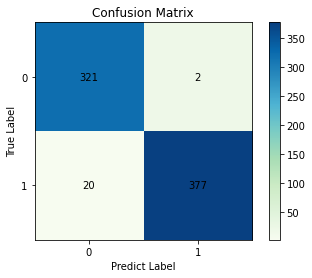

In [18]:
#繪製混淆矩陣
import matplotlib.pyplot as plt
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(confusion_mat)):
        for y in range(len(confusion_mat)):
            plt.annotate(confusion_mat[x, y], xy=(x, y),horizontalalignment='center',verticalalignment='center')
    plt.title('Confusion Matrix')    
    plt.ylabel('True Label')         
    plt.xlabel('Predict Label')     
    tick_marks = np.arange(2)
    plt.xticks(tick_marks,tick_marks)
    plt.yticks(tick_marks,tick_marks)
    plt.show()
from sklearn import metrics
confusion_mat=metrics.confusion_matrix(df_test.label, df_test.predict_label,labels=None,sample_weight=None)
plot_confusion_matrix(confusion_mat)

In [19]:
#產生分類報告
from sklearn.metrics import classification_report
print(classification_report(df_test.label, df_test.predict_label,digits=4))

              precision    recall  f1-score   support

           0     0.9938    0.9413    0.9669       341
           1     0.9496    0.9947    0.9716       379

    accuracy                         0.9694       720
   macro avg     0.9717    0.9680    0.9693       720
weighted avg     0.9705    0.9694    0.9694       720



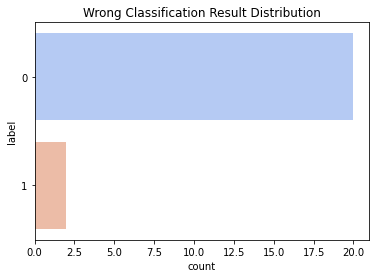

In [20]:
#找出分類錯誤的label並視覺化
import seaborn as sns
wrong_df=df_test[df_test.label != df_test.predict_label]
sns.countplot(y="label",palette="coolwarm",data=wrong_df).set_title('Wrong Classification Result Distribution')
plt.show()

In [21]:
#找出分類錯誤的文章
wrong_titles=df_test[df_test.label != df_test.predict_label].title.values
wrong_titles=pd.DataFrame(wrong_titles)
wrong_report=wrong_titles.to_excel("TFC_WrongReport.xlsx")